In [26]:
# Importing the libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
plt.style.use('fivethirtyeight')

# !pip yfinance ta
import yfinance as yf
import ta 

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [27]:
consider_every_Nth_day = 1 # used in CCI loops only. 10 means biweekly (10 trading days in 2 weeks)
Starting_cash = 10_000
STOCK = 'SPY'

In [28]:
start="2017-01-01"
# start="2013-3-14"
# start="2000-01-01"
df = yf.download(STOCK, start) 
# df = df.drop(columns=['Open','High', 'Low','Adj Close','Volume'])
# df['MA'] = df.Close.rolling(window=5).mean().fillna(df.Close[0])
df.dropna(inplace=True)
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,199.819519,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,201.008316,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,200.848618,78379000


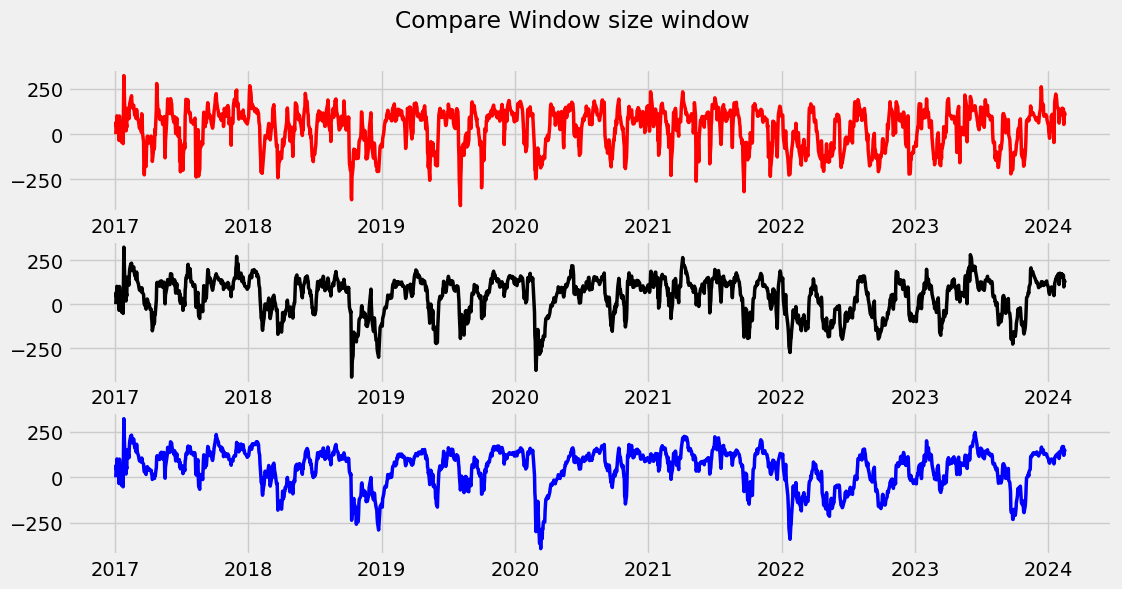

In [29]:
C = 0.015 # 0.015
cci1 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=20, constant=C, fillna=True) # 'n' is now 'window'; 'c' is not 'constant'... damn API changes. current version on ta broke several notebooks. This is why I rerun past code every few years 
cci2 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=40, constant=C, fillna=True)
cci3 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=60, constant=C, fillna=True)


fig, axs = plt.subplots(3, figsize=(12,6))
_=fig.suptitle('Compare Window size window')


_=axs[0].plot(cci1, color='r', linewidth=2.5) #, alpha = 1.0)
_=axs[1].plot(cci2, color='k', linewidth=2.5) #, alpha = 1.0)
_=axs[2].plot(cci3, color='b', linewidth=2.5) #, alpha = 0.85)
plt.show()

In [30]:
df["cci"] = cci1
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,cci
Date,,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,199.819519,91366500,0.000000
2017-01-04,225.619995,226.750000,225.610001,226.580002,201.008316,78744400,66.666667
2017-01-05,226.270004,226.580002,225.479996,226.399994,200.848618,78379000,40.399741
2017-01-06,226.529999,227.750000,225.899994,227.210007,201.567184,71559900,101.715415
2017-01-09,226.910004,227.070007,226.419998,226.460007,200.901855,46939700,56.997366


## Plot days in which the CCI is > N

CV (all): 23.18
CV (greed): 21.44
CV (red): 29.83


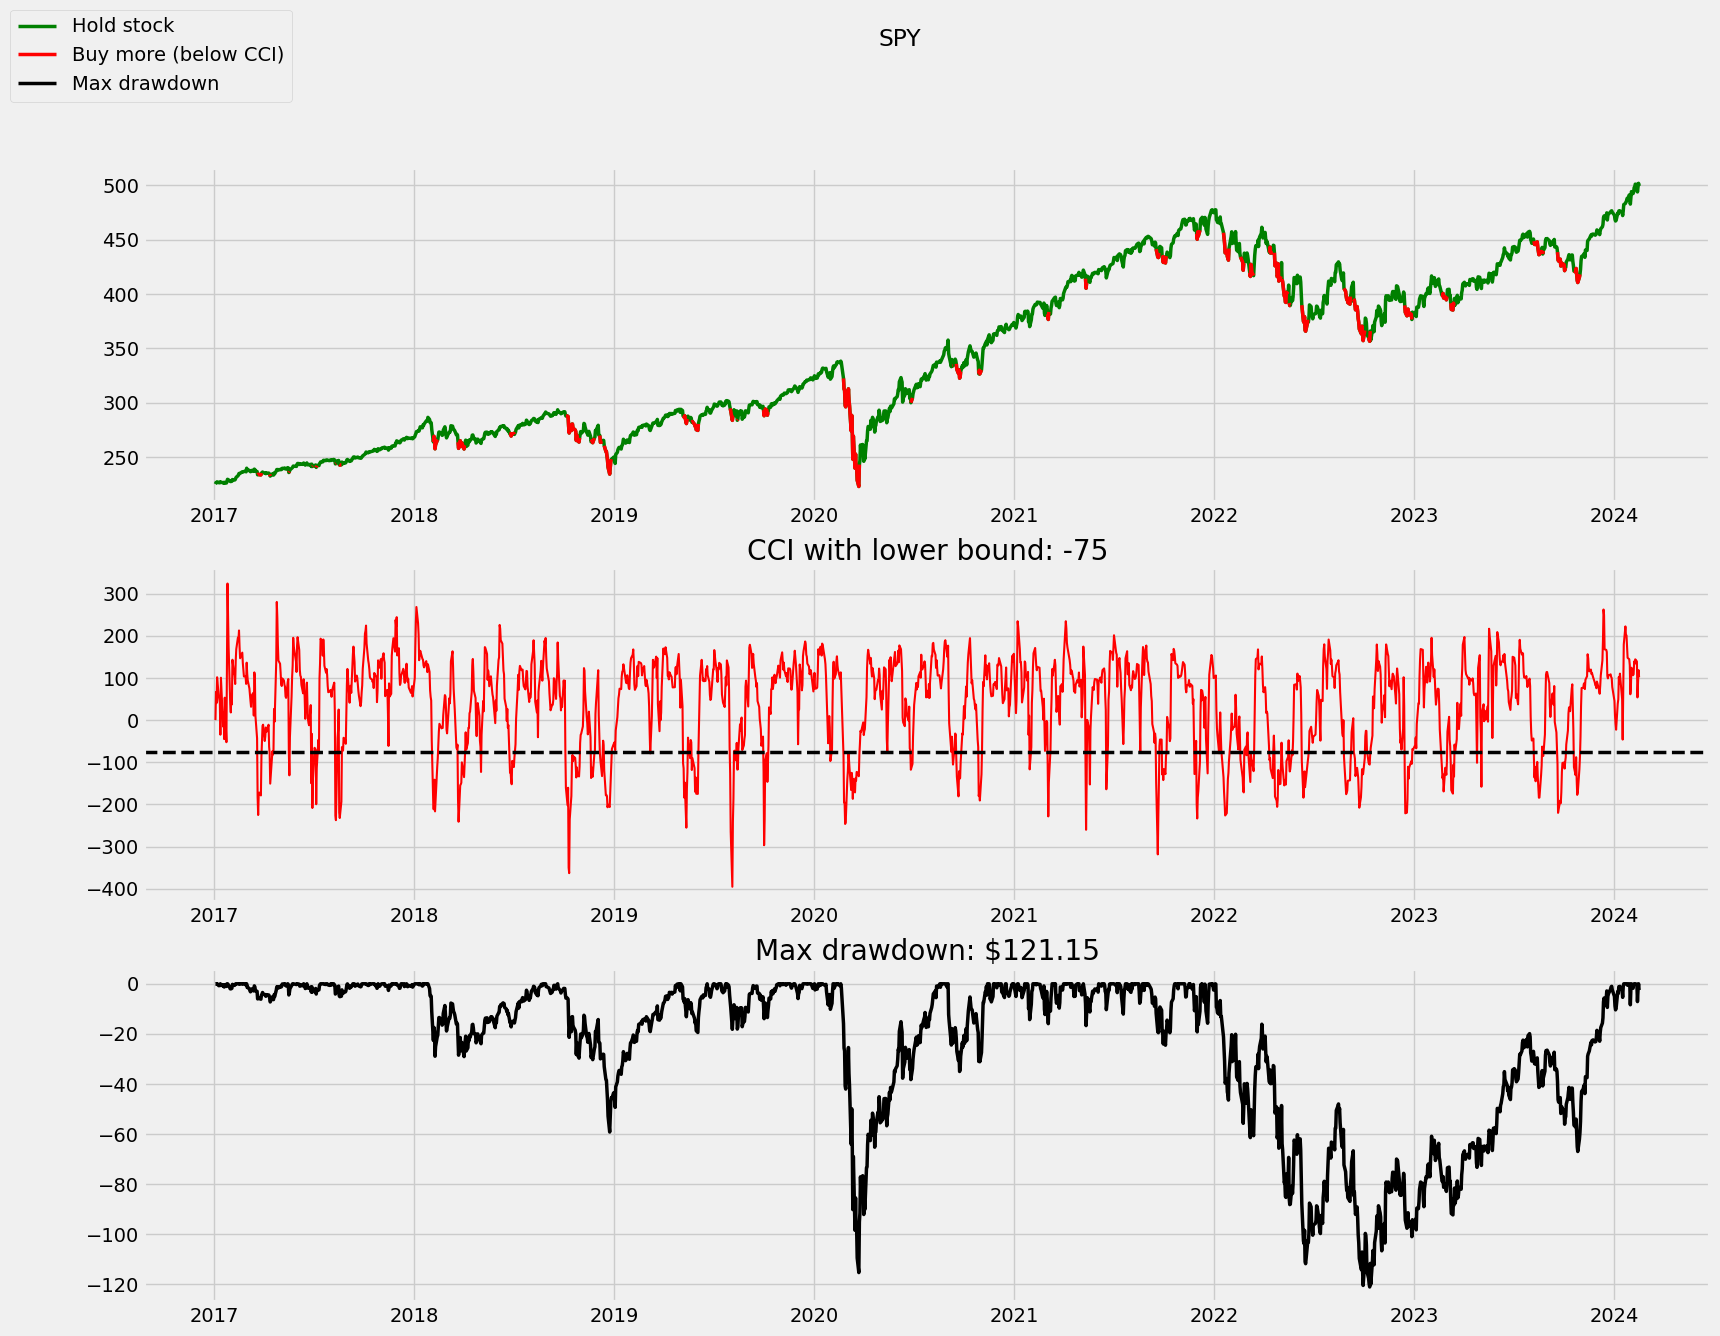

In [76]:
def plot(lowerBound=-100, upperBound=float('inf'), dataset=df):
    #dataset = dataset.copy()
    tmp = dataset[(dataset['cci'] > lowerBound) & (dataset['cci'] < upperBound)]
    all = set(dataset.index.values)
    in_market = set(tmp.index.values)
    idx_not_in_market = list(all-in_market)

    dataset['days_in_market'] = dataset.loc[list(in_market)].sort_index()['Close']
    
    dataset['day_not_in_market'] = dataset.loc[idx_not_in_market].sort_index()['Close']
        
    fig, axs = plt.subplots(3, gridspec_kw={'height_ratios': [2, 2, 2]}) # , figsize=(24, 9)
    fig.suptitle(f"{STOCK.upper()}")
    fig.set_figheight(14)
    fig.set_figwidth(18)
    # 0 
    axs[0].plot(dataset['Close'], color='green', linewidth=2.5, label='Hold stock') #, alpha = 1.0)
    axs[0].plot(dataset['day_not_in_market'], color='red', linewidth=2.5, label='Buy more (below CCI)') #, alpha = 1.0)
    
    # 1
    axs[1].plot(dataset['cci'], color='red', linewidth=1.5) #, alpha = 1.0)
    axs[1].axhline(lowerBound, linewidth=2.5, color="black", linestyle="--")
    if upperBound != float('inf'):
        axs[1].axhline(upperBound, linewidth=2.5, color="black", linestyle="--")
    #set sub title
    axs[1].title.set_text(f"CCI with lower bound: {lowerBound}")

    # 2
    axs[2].plot(dataset['Close'] - dataset['Close'].cummax(), color='black', linewidth=2.5, label='Max drawdown')
    axs[2].title.set_text(f"Max drawdown: ${-1*(dataset['Close'] - dataset['Close'].cummax()).min() :.02f}")

    fig.legend(loc="upper left")

    CV_all = dataset['Close'].pct_change().dropna().std() / dataset['Close'].pct_change().dropna().mean()
    CV_in_market = dataset['days_in_market'].pct_change().dropna().std()  / dataset['days_in_market'].pct_change().dropna().mean()
    CV_not_in_market = dataset['day_not_in_market'].pct_change().dropna().std()  / dataset['day_not_in_market'].pct_change().dropna().mean()
    print(f"CV (all): {CV_all:.2f}")
    print(f"CV (greed): {CV_in_market:.2f}")
    print(f"CV (red): {CV_not_in_market:.2f}")
    return dataset['days_in_market']
    
    # date = dataset.index[-1] - dataset.index[0]
    # years = date.days/365.25
    # print(f"years {years:.2f}")

    # total = simulate_stratergy(lower=lowerBound, upper=upperBound, consider_every_Nth_day=1, quite=True)
    # print(f"Total return: {total:.2f}%")
    # print(f"Annual return: {total/years:.2f}%")

    # std = dataset['days_in_market'].std()

tmp = plot(lowerBound=-75)

## Buy and Hold

In [7]:
start, end = df.Close.values[0], df.Close.values[-1]
start
end

shares =  Starting_cash/start
base_strategy = round(shares * end, 2)

print(f"Numb of shares: {shares:.2f}")
print(f"Total return: {base_strategy:.2f}")


date_range = df.index[-1] - df.index[0]
years = date_range.days/365.25

base_strategy_return = (base_strategy-Starting_cash)/Starting_cash
rate = base_strategy_return / 100
rate = ((rate + 1)**(1 / years)) - 1 # https://stackoverflow.com/a/52618808/5728614
percent = rate * 100
print(f"ROI: {base_strategy_return:.2f}x")
print(f"Annualized return: {percent*100:.2f}%")
print(f"years: {years:.2f}")
print(f'Quick check {((1 + percent/100)**years-1)*100 :.2f} vs {base_strategy_return:.2f}')


225.24000549316406

499.510009765625

Numb of shares: 44.40
Total return: 22176.79
ROI: 1.22x
Annualized return: 17.02%
years: 7.12
Quick check 1.22 vs 1.22


In [8]:
## not working
# risk_free_rate = 4
# percent_rate = percent
# std = (df['Close'].std() * np.sqrt(years))
# print(percent_rate)
# print(std)

# sharpe_ratio = (percent_rate - risk_free_rate) / std
# print(f"Sharpe ratio: {sharpe_ratio}")

# https://www.codearmo.com/blog/sharpe-sortino-and-calmar-ratios-python
df_ = df['Close'].pct_change().dropna()
N = 252 #252 trading days in a year
rf = 0.02 #1% risk free rate
mean = df_.mean() * N -rf
sigma = df_.std() * np.sqrt(N)
sharpe_ratio = mean / sigma
print(sharpe_ratio)


0.579630654937877


In [9]:
def simulate_stratergy(lower = -100, upper = float('inf'), consider_every_Nth_day=consider_every_Nth_day, useZero=False, quite=False):
    # dataset = df.copy().iloc[0::consider_every_Nth_day]
    dataset = df.iloc[0::consider_every_Nth_day]

    shares = 0 
    cash = Starting_cash
    for i in dataset.index:
        cci = dataset.loc[i].at['cci']
        close = dataset.loc[i].at['Close']

        if useZero:
            # trade using the zero line
            if cci >= 0:
                # buy
                numb_shares_buying = cash/close # assume fractional shares
                shares+=numb_shares_buying
                cash -= (close * numb_shares_buying)    
            else:
                cash += (close * shares)
                shares=0

        else:
            # normal way
            if(cci > upper):
                # sell
                cash += (close * shares)
                shares=0

            elif(cci <= lower): # or np.isnan(Cci) # prevents exactly "buy and hold" as for the first 40 days (2 iterations) cci is NaN
                # buy 
                numb_shares_buying = cash/close
                shares+=numb_shares_buying
                cash -= (close * numb_shares_buying)

    total = dataset.Close[-1]*shares + cash

    if quite:
        return total    
    print(f"[{lower} to {upper}]\t Made {total:.2f} compared to {base_strategy:.2f}. For a {100*(total-base_strategy)/base_strategy:.4f}% change")

simulate_stratergy(lower = -100, upper = 0)
simulate_stratergy(lower = -100, upper = 100)
simulate_stratergy(lower = -100, upper = 200)
simulate_stratergy(lower = -50,  upper = 0)
simulate_stratergy(lower = -50,  upper = 100)
simulate_stratergy(lower = -50,  upper = 200)
simulate_stratergy(lower = 0,    upper = 100)
simulate_stratergy(lower = 0,    upper = 200)

print("-----------------")
print("No selling")
simulate_stratergy(lower = -200)
simulate_stratergy(lower = -150)
simulate_stratergy(lower = -75)
simulate_stratergy(lower = -30)
simulate_stratergy(lower = 0)
simulate_stratergy(lower = 999)

print("-----------------")
print("Buy and Sell across CCI=0")
simulate_stratergy(lower = 0, upper = 0, useZero=True)

[-100 to 0]	 Made 9899.39 compared to 22176.79. For a -55.3615% change
[-100 to 100]	 Made 11998.08 compared to 22176.79. For a -45.8980% change
[-100 to 200]	 Made 17788.46 compared to 22176.79. For a -19.7879% change
[-50 to 0]	 Made 12334.15 compared to 22176.79. For a -44.3826% change
[-50 to 100]	 Made 14714.73 compared to 22176.79. For a -33.6481% change
[-50 to 200]	 Made 20851.49 compared to 22176.79. For a -5.9761% change
[0 to 100]	 Made 16088.48 compared to 22176.79. For a -27.4535% change
[0 to 200]	 Made 21144.59 compared to 22176.79. For a -4.6544% change
-----------------
No selling
[-200 to inf]	 Made 18352.87 compared to 22176.79. For a -17.2429% change
[-150 to inf]	 Made 19357.10 compared to 22176.79. For a -12.7146% change
[-75 to inf]	 Made 19388.66 compared to 22176.79. For a -12.5723% change
[-30 to inf]	 Made 22050.50 compared to 22176.79. For a -0.5695% change
[0 to inf]	 Made 22176.79 compared to 22176.79. For a -0.0000% change
[999 to inf]	 Made 22176.79 comp

### Plot..


[0 to 300]	 Made 15218.14 compared to 22176.79. For a -31.3781% change
CV (all): 23.18
CV (greed): 16.35
CV (red): 27.28


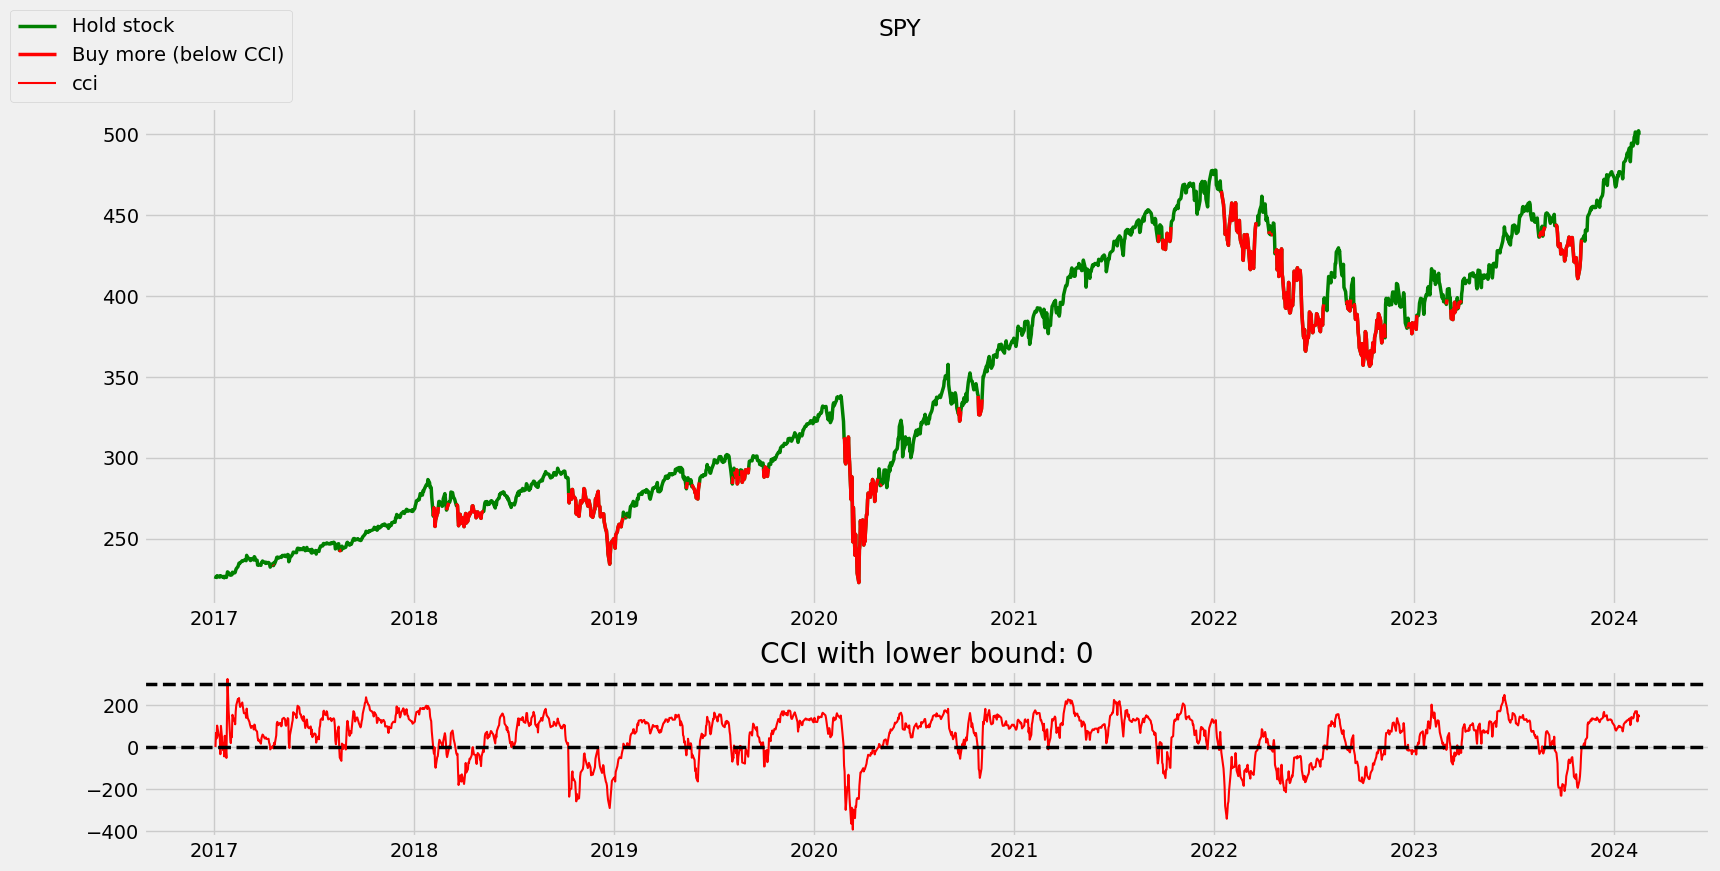

In [18]:
simulate_stratergy(lower = 0, upper=300, useZero=True)
plot(lowerBound=0, upperBound=300)

### Optimize the CCI bounds

In [11]:
def find_optimal_range(dataset=df):
  dataset = dataset.iloc[0::consider_every_Nth_day] #[1::20] start at 1, every 20th (monthly)
  
  step_size = 20
  cci_min = int(dataset['cci'].min())
  cci_max = int(dataset['cci'].max())

  top_total = 0
  top_min = 0
  top_max = 0

  for max in np.arange(cci_min, cci_max, step_size): # -200+step_size
    print(f'\nmax is {max} min is ', end="")

    for min in np.arange(cci_min, max, step_size):
        print(f'{min} ', end="")

        total = simulate_stratergy(lower=min, upper=max, consider_every_Nth_day=consider_every_Nth_day, quite=True)

        if(total > top_total):
            top_total = total
            top_min, top_max = min, max 

  print("\n=======================================")
  print(f"[{top_min} to {top_max}]\t Made {total:.2f} compared to {base_strategy:.2f}")
  print(f"For a {100*(total-base_strategy)/base_strategy:.4f}% change")


resultOfCCStrat = find_optimal_range()


max is -393 min is 
max is -373 min is -393 
max is -353 min is -393 -373 
max is -333 min is -393 -373 -353 
max is -313 min is -393 -373 -353 -333 
max is -293 min is -393 -373 -353 -333 -313 
max is -273 min is -393 -373 -353 -333 -313 -293 
max is -253 min is -393 -373 -353 -333 -313 -293 -273 
max is -233 min is -393 -373 -353 -333 -313 -293 -273 -253 
max is -213 min is -393 -373 -353 -333 -313 -293 -273 -253 -233 
max is -193 min is -393 -373 -353 -333 -313 -293 -273 -253 -233 -213 
max is -173 min is -393 -373 -353 -333 -313 -293 -273 -253 -233 -213 -193 
max is -153 min is -393 -373 -353 -333 -313 -293 -273 -253 -233 -213 -193 -173 
max is -133 min is -393 -373 -353 -333 -313 -293 -273 -253 -233 -213 -193 -173 -153 
max is -113 min is -393 -373 -353 -333 -313 -293 -273 -253 -233 -213 -193 -173 -153 -133 
max is -93 min is -393 -373 -353 -333 -313 -293 -273 -253 -233 -213 -193 -173 -153 -133 -113 
max is -73 min is -393 -373 -353 -333 -313 -293 -273 -253 -233 -213 -193 -173 -1